In [ ]:
import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# /content/drive/MyDrive/SM-Forcasting/dataset

In [ ]:
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from tqdm import tqdm

In [ ]:
price_data = pd.read_csv('/content/drive/MyDrive/SM-Forcasting/dataset/stockmarket_data.csv')
news_data = pd.read_csv('/content/drive/MyDrive/SM-Forcasting/newsheadlines/sp500.csv')

In [ ]:
price_data = price_data[['Date', '^GSPC S&P 500 (United States)']]

In [ ]:
price_data.head()

,Date,^GSPC S&P 500 (United States)
0,06/10/05,1198.1
1,13/06/05,1200.8
2,14/06/05,1203.9
3,15/06/05,1206.6
4,16/06/05,1211.0


In [ ]:
model_name = "yiyanghkust/finbert-tone"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

In [ ]:
def get_sentiment_score(text):
    if not isinstance(text, str) or not text.strip():
        return {'positive': 0.0, 'negative': 0.0, 'neutral': 1.0}
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        sentiments = {label: float(prob) for label, prob in zip(['negative', 'neutral', 'positive'], probs[0])}
    return sentiments

In [ ]:
sentiment_scores = {}
for date, group in tqdm(news_data.groupby('Date'), desc="Processing News Sentiment"):
    headlines = group['NewsTitle'].tolist()
    if headlines:
        sentiments = [get_sentiment_score(headline) for headline in headlines]
        avg_sentiment = {
            'positive': np.mean([s['positive'] for s in sentiments]),
            'negative': np.mean([s['negative'] for s in sentiments]),
            'neutral': np.mean([s['neutral'] for s in sentiments])
        }
        sentiment_scores[date] = avg_sentiment
    else:
        sentiment_scores[date] = {'positive': 0.0, 'negative': 0.0, 'neutral': 1.0}

Processing News Sentiment:   0%|          | 0/4114 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

Processing News Sentiment: 100%|██████████| 4114/4114 [18:35<00:00,  3.69it/s]


In [ ]:
sentiment_df = pd.DataFrame.from_dict(sentiment_scores, orient='index').reset_index()
sentiment_df = sentiment_df.rename(columns={'index': 'Date'})
sentiment_df['Date'] = pd.to_datetime(sentiment_df['Date'])

In [ ]:
import pandas as pd

price_data['Date'] = pd.to_datetime(price_data['Date'])
sentiment_df['Date'] = pd.to_datetime(sentiment_df['Date'])

combined_df = pd.merge(price_data, sentiment_df, on='Date', how='left')

# Fill NaN values in sentiment columns with default values
combined_df[['positive', 'negative', 'neutral']] = combined_df[['positive', 'negative', 'neutral']].fillna({
    'positive': 0.0,
    'negative': 0.0,
    'neutral': 1.0
})

print(combined_df.head())


<ipython-input-13-58a19d565369>:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  price_data['Date'] = pd.to_datetime(price_data['Date'])


        Date  ^GSPC S&P 500 (United States)  positive  negative   neutral
0 2005-06-10                         1198.1  0.000000  0.000000  1.000000
1 2005-06-13                         1200.8  0.000507  0.999487  0.000006
2 2005-06-14                         1203.9  0.000000  0.000000  1.000000
3 2005-06-15                         1206.6  0.000000  0.000000  1.000000
4 2005-06-16                         1211.0  0.000000  0.000000  1.000000


In [ ]:
combined_df.to_csv('sp500_with_sentiment.csv', index=False)

In [ ]:
combined_df['Price_Change'] = combined_df['^GSPC S&P 500 (United States)'].pct_change()
combined_df['Sentiment_Score'] = combined_df['positive'] - combined_df['negative']
print("\nCorrelation between Sentiment Score and Price Change:")
print(combined_df[['Sentiment_Score', 'Price_Change']].corr())


Correlation between Sentiment Score and Price Change:
                 Sentiment_Score  Price_Change
Sentiment_Score          1.00000      -0.05196
Price_Change            -0.05196       1.00000


<ipython-input-16-3831d2f95939>:1: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  combined_df['Price_Change'] = combined_df['^GSPC S&P 500 (United States)'].pct_change()


calculate it for log return

In [ ]:
news_df =  pd.read_csv('/content/drive/MyDrive/SM-Forcasting/newsheadlines/sp500.csv')
sp500_df = pd.read_csv('/content/drive/MyDrive/SM-Forcasting/dataset/stockmarket_data.csv')

In [ ]:
sp500_df = price_data[['Date', '^GSPC S&P 500 (United States)']]

In [ ]:
news_df['Date'] = pd.to_datetime(news_df['Date'], errors='coerce')
sp500_df['Date'] = pd.to_datetime(sp500_df['Date'], format='%m/%d/%y', errors='coerce')

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('ProsusAI/finbert')
model = AutoModelForSequenceClassification.from_pretrained('ProsusAI/finbert')

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [ ]:
def get_sentiment_score(headline):
    if pd.isna(headline) or not isinstance(headline, str):
        return 0
    inputs = tokenizer(headline, return_tensors="pt", padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    probabilities = torch.softmax(outputs.logits, dim=1)
    # FinBERT labels: 0 = negative, 1 = neutral, 2 = positive
    negative_prob = probabilities[0][0].item()
    positive_prob = probabilities[0][2].item()
    sentiment_score = positive_prob - negative_prob
    return sentiment_score

In [ ]:
news_df.head()

,Date,NewsTitle
0,2000-01-02,"Wall Street kicks off 2000 - Jan. 2, 2000"
1,2000-01-02,"Wall Street kicks off 2000 - Jan. 2, 2000"
2,2000-01-02,"Wall Street kicks off 2000 - Jan. 2, 2000"
3,2000-01-03,"Dow falters; Nasdaq gains - Jan. 3, 2000"
4,2000-01-03,"Dow falters; Nasdaq gains - Jan. 3, 2000"


In [ ]:
from tqdm import tqdm

In [ ]:
tqdm.pandas(desc="Processing Sentiment Scores")

In [ ]:
news_df['sentiment_score'] = news_df['NewsTitle'].progress_apply(get_sentiment_score)

Processing Sentiment Scores: 100%|██████████| 9844/9844 [19:20<00:00,  8.48it/s]


In [ ]:
daily_sentiment = news_df.groupby('Date')['sentiment_score'].mean().reset_index()

In [ ]:
sp500_df.head()

,Date,^GSPC S&P 500 (United States)
0,2005-06-10,1198.1
1,2005-06-13,1200.8
2,2005-06-14,1203.9
3,2005-06-15,1206.6
4,2005-06-16,1211.0


In [ ]:
merged_df = pd.merge(sp500_df[['Date', '^GSPC S&P 500 (United States)']], daily_sentiment, on='Date', how='left')
merged_df['sentiment_score'] = merged_df['sentiment_score'].fillna(0)

In [ ]:
merged_df = merged_df.rename(columns={'^GSPC': 'S&P 500 Closing Price'})
merged_df.to_csv('sp500With_sentiment.csv', index=False)

In [ ]:
merged_df.head()

,Date,^GSPC S&P 500 (United States),sentiment_score
0,2005-06-10,1198.1,0.000000
1,2005-06-13,1200.8,0.474658
2,2005-06-14,1203.9,0.000000
3,2005-06-15,1206.6,0.000000
4,2005-06-16,1211.0,0.000000


In [ ]:
merged_df['Price_Change'] = merged_df['^GSPC S&P 500 (United States)'].pct_change()


correlation_matrix = merged_df[['sentiment_score', 'Price_Change']].corr()

print("\nCorrelation between Sentiment Score and Price Change:")
print(correlation_matrix)



Correlation between Sentiment Score and Price Change:
                 sentiment_score  Price_Change
sentiment_score         1.000000     -0.040431
Price_Change           -0.040431      1.000000


<ipython-input-42-18c80deb5898>:2: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  merged_df['Price_Change'] = merged_df['^GSPC S&P 500 (United States)'].pct_change()


In [2]:
combined_df = pd.read_csv("/content/sp500_with_sentiment.csv")

In [4]:
combined_df.head()

,Date,^GSPC S&P 500 (United States),positive,negative,neutral
0,2005-06-10,1198.1,0.000000,0.000000,1.000000
1,2005-06-13,1200.8,0.000507,0.999487,0.000006
2,2005-06-14,1203.9,0.000000,0.000000,1.000000
3,2005-06-15,1206.6,0.000000,0.000000,1.000000
4,2005-06-16,1211.0,0.000000,0.000000,1.000000


In [ ]:
### For Log return

import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm

# Load Data
price_data = pd.read_csv('/content/drive/MyDrive/SM-Forcasting/dataset/stockmarket_data.csv')
news_data = pd.read_csv('/content/drive/MyDrive/SM-Forcasting/newsheadlines/sp500.csv')

# Extract required columns
price_data = price_data[['Date', '^GSPC S&P 500 (United States)']]

# Rename column for convenience
price_data.rename(columns={'^GSPC S&P 500 (United States)': 'Price'}, inplace=True)

# Convert Date column to datetime
price_data['Date'] = pd.to_datetime(price_data['Date'])
news_data['Date'] = pd.to_datetime(news_data['Date'])

# Compute log returns
price_data['Log_Return'] = np.log(price_data['Price'] / price_data['Price'].shift(1))
price_data.dropna(inplace=True)  # Remove NaN values from log return calculation

# Load FinBERT model
model_name = "yiyanghkust/finbert-tone"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Function to get sentiment score
def get_sentiment_score(text):
    if not isinstance(text, str) or not text.strip():
        return {'positive': 0.0, 'negative': 0.0, 'neutral': 1.0}

    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        sentiments = {label: float(prob) for label, prob in zip(['negative', 'neutral', 'positive'], probs[0])}

    return sentiments

# Compute average sentiment scores per date
sentiment_scores = {}
for date, group in tqdm(news_data.groupby('Date'), desc="Processing News Sentiment"):
    headlines = group['NewsTitle'].tolist()

    if headlines:
        sentiments = [get_sentiment_score(headline) for headline in headlines]
        avg_sentiment = {
            'positive': np.mean([s['positive'] for s in sentiments]),
            'negative': np.mean([s['negative'] for s in sentiments]),
            'neutral': np.mean([s['neutral'] for s in sentiments])
        }
        sentiment_scores[date] = avg_sentiment
    else:
        sentiment_scores[date] = {'positive': 0.0, 'negative': 0.0, 'neutral': 1.0}

# Convert sentiment dictionary to DataFrame
sentiment_df = pd.DataFrame.from_dict(sentiment_scores, orient='index').reset_index()
sentiment_df.rename(columns={'index': 'Date'}, inplace=True)
sentiment_df['Date'] = pd.to_datetime(sentiment_df['Date'])

# Merge sentiment scores with log return data
combined_df = pd.merge(price_data, sentiment_df, on='Date', how='left')

# Fill NaN values in sentiment columns with default values
combined_df[['positive', 'negative', 'neutral']] = combined_df[['positive', 'negative', 'neutral']].fillna({
    'positive': 0.0,
    'negative': 0.0,
    'neutral': 1.0
})


print(combined_df.head())


<ipython-input-7-608884a7d3c3>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_data.rename(columns={'^GSPC S&P 500 (United States)': 'Price'}, inplace=True)
<ipython-input-7-608884a7d3c3>:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  price_data['Date'] = pd.to_datetime(price_data['Date'])
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret

config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

Processing News Sentiment:   0%|          | 0/4114 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

Processing News Sentiment:  99%|█████████▉| 4077/4114 [20:05<00:16,  2.20it/s]

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


98/98 ━━━━━━━━━━━━━━━━━━━━ 19s 107ms/step - loss: 0.0092 - val_loss: 0.0010
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 20s 100ms/step - loss: 0.0013 - val_loss: 7.5385e-04
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step - loss: 8.7560e-04 - val_loss: 6.8781e-04
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - loss: 9.4626e-04 - val_loss: 0.0014
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 10s 100ms/step - loss: 7.5827e-04 - val_loss: 0.0011
Epoch 6/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 10s 98ms/step - loss: 6.8263e-04 - val_loss: 0.0013
Epoch 7/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - loss: 5.5061e-04 - val_loss: 6.5827e-04
Epoch 8/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 12s 102ms/step - loss: 5.6514e-04 - val_loss: 7.7577e-04
Epoch 9/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 10s 102ms/step - loss: 4.8845e-04 - val_loss: 8.2144e-04
Epoch 10/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - loss: 4.3590e-04 - val_loss: 7.5142e-04
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step


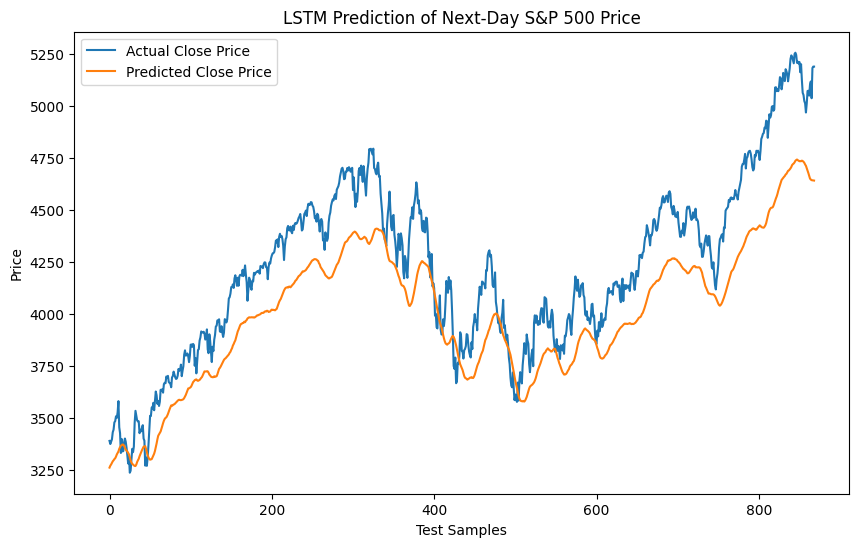

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Assuming 'combined_df' exists with the following columns:
#   Date, ^GSPC S&P 500 (United States), positive, negative, neutral
# Rename the price column for convenience:
combined_df.rename(columns={'^GSPC S&P 500 (United States)': 'Close'}, inplace=True)

# Sort by date in case it's not already sorted
combined_df.sort_values(by='Date', inplace=True)
combined_df.dropna(subset=['Close'], inplace=True)

# Select features (Close price + sentiments)
features = ['Close', 'positive', 'negative', 'neutral']
data = combined_df[features].values

# Scale data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Convert time-series to supervised sequences
def create_sequences(dataset, seq_length=20):
    X, y = [], []
    for i in range(seq_length, len(dataset)):
        X.append(dataset[i-seq_length:i])
        # Predict the 'Close' value in the next time step (index 0 in scaled features)
        y.append(dataset[i, 0])
    return np.array(X), np.array(y)

SEQ_LENGTH = 100  # or any length you consider best
X_all, y_all = create_sequences(data_scaled, SEQ_LENGTH)

# Split into train and test (e.g., 80% train, 20% test)
train_size = int(len(X_all) * 0.8)
X_train, X_test = X_all[:train_size], X_all[train_size:]
y_train, y_test = y_all[:train_size], y_all[train_size:]

# Build LSTM model
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1, verbose=1)

# Prediction
predictions_scaled = model.predict(X_test)
# We only scaled the data, so let's invert the scale for the 'Close' (first column)
# Create an array to invert the scaling properly
num_features = len(features)
inv_pred = np.zeros((len(predictions_scaled), num_features))
inv_pred[:, 0] = predictions_scaled[:, 0]
predictions = scaler.inverse_transform(inv_pred)[:, 0]

# Invert the true test values
inv_y_test = np.zeros((len(y_test), num_features))
inv_y_test[:, 0] = y_test
true_values = scaler.inverse_transform(inv_y_test)[:, 0]

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(true_values, label='Actual Close Price')
plt.plot(predictions, label='Predicted Close Price')
plt.title('LSTM Prediction of Next-Day S&P 500 Price')
plt.xlabel('Test Samples')
plt.ylabel('Price')
plt.legend()
plt.show()